<a href="https://colab.research.google.com/github/saritadas007/WWC_Machine-Learning-Study-Group-/blob/main/Indian_street_food_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinu

Get images

In [11]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(image_term, max_images=30):
    print(f"Searching for '{image_term}'")
    with DDGS() as ddgs:
        # generator which yields dicts with:
        # {'title','image','thumbnail','url','height','width','source'}
        search_results = ddgs.images(keywords=image_term)
        # grap number of max_images urls
        # image_urls = [next(search_results).get("image") for _ in range(max_images)]
        image_urls = [result.get("image") for result, _ in zip(search_results, range(max_images))]
        # convert to L (functionally extended list class from fastai)
        return L(image_urls)

# example usage:
urls = search_images("Dahi bara aludum", max_images=10)
print(urls[0])

Searching for 'Dahi bara aludum'
https://www.bhubaneswarbuzz.com/wp-content/uploads/2014/12/dahibara-aloodam-turmeric-kitchen.png


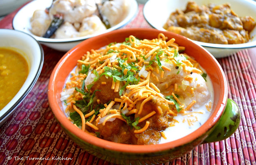

In [22]:
from fastdownload import download_url
dest = 'dahibara.jpg'
download_url(urls[0], dest, show_progress=False)
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'Gupchup photos'


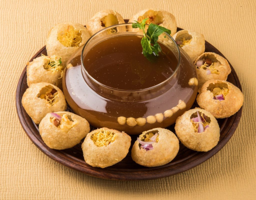

In [10]:
download_url(search_images('Gupchup photos', max_images=1)[0], 'Gupchup.jpg', show_progress=False)
Image.open('Gupchup.jpg').to_thumb(256,256)

In [34]:
searches = 'Dahi bara aludum','Gupchup'
path = Path('Gupchup_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} at home photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} at road side photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Dahi bara aludum photo'
Searching for 'Dahi bara aludum at home photo'
Searching for 'Dahi bara aludum at road side photo'
Searching for 'Gupchup photo'
Searching for 'Gupchup at home photo'
Searching for 'Gupchup at road side photo'


In [35]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

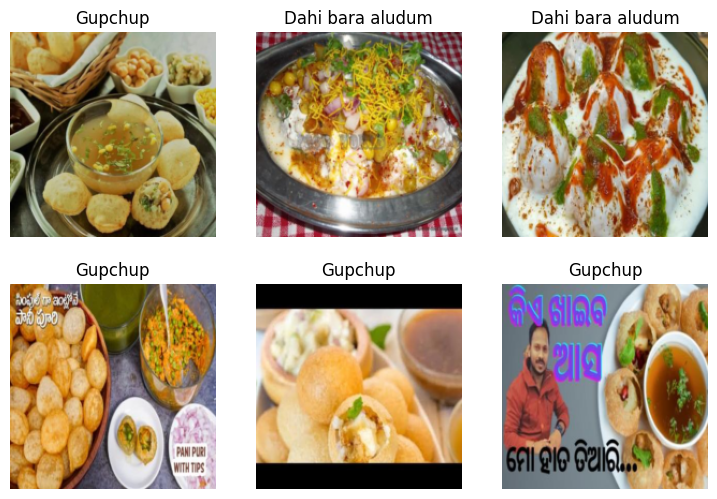

In [36]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [41]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.209588,0.506412,0.151515,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.648256,0.410852,0.181818,00:30
1,0.466977,0.328955,0.121212,00:30
2,0.367952,0.325921,0.151515,00:31
3,0.273420,0.339929,0.151515,00:29
4,0.218367,0.343798,0.151515,00:30


This is : Gupchup.
Probability it's dahibara: 0.0000
Probability it's gupchup: 1.0000


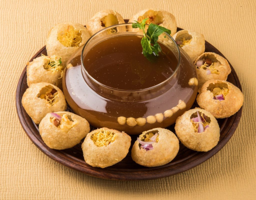

In [49]:
is_dahibara,_,probs = learn.predict(PILImage.create('Gupchup.jpg'))
print(f"This is : {is_dahibara}.")
print(f"Probability it's dahibara: {probs[0]:.4f}")
print(f"Probability it's gupchup: {probs[1]:.4f}")


from fastai.vision.all import *
im = Image.open('Gupchup.jpg')
im.to_thumb(256,256)